In [11]:
from datasets import generate_x_y_data_v1 as generate_data
import numpy as np
import matplotlib.pyplot as plt

In [12]:
sample_x, sample_y = generate_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

Dimensions of the dataset for 3 X and 3 Y training examples : 
(10, 3, 2)
(10, 3, 2)
(seq_length, batch_size, output_dim)


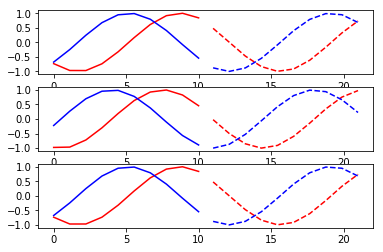

In [13]:
import math

plt.figure()
x_axis = np.linspace(0, 10, 10)
for i in range(3):
    plt.subplot(311+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
    plt.plot(x_axis+11, sample_y[:, i, 0], 'r--', x_axis+11, sample_y[:, i, 1], 'b--')

plt.show()

In [14]:
from model.decoders import Decoder
from model.encoders import Encoder
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Internal neural network parameters
# Time series will have the same past and future (to be predicted) lenght.
seq_length = sample_x.shape[1]
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = input_dim = sample_x.shape[-1]
hidden_dim = 12  # Count of hidden neurons in the recurrent units.
# Number of stacked recurrent cells, on the neural depth axis.
layers_stacked_count = 1

# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.
# How many times we perform a training step (therefore how many times we
# show a batch).
nb_iters = 150
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [15]:
test_encoder = Encoder(input_dim, hidden_dim, number_of_layers=layers_stacked_count)

# initialize the hidden state(num_layers, batch_size, hidden_size).
hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))

sample_x, sample_y = generate_data(isTrain=True, batch_size=batch_size)
input_x = autograd.Variable(torch.FloatTensor(sample_x), requires_grad=False)

print(test_encoder)

Encoder (
  (encoder): LSTM(2, 12)
)


In [16]:
encoder_output, encoder_state = test_encoder(input_x,hidden)
print(encoder_output[-1])

Variable containing:

Columns 0 to 9 
-0.0583  0.0096  0.0322  0.1820 -0.0061  0.0309  0.1540  0.0132 -0.0995  0.0209
 0.1280  0.2783 -0.0840  0.0334 -0.2284  0.1586 -0.0267  0.0464  0.1511 -0.0989
 0.0449  0.0561  0.0178  0.1636 -0.0842  0.0615  0.1421  0.0233 -0.0763 -0.0096
-0.0604  0.2154 -0.1795  0.0745 -0.0713  0.1168 -0.0558  0.0227  0.1920 -0.0350
 0.1238  0.2832 -0.0765  0.0325 -0.2316  0.1631 -0.0216  0.0500  0.1513 -0.0979

Columns 10 to 11 
-0.0723 -0.0463
-0.0360 -0.1506
-0.0764 -0.0954
-0.0037 -0.0607
-0.0359 -0.1506
[torch.FloatTensor of size 5x12]



In [17]:
test_decoder = Decoder(hidden_dim, hidden_dim, output_dim, number_of_layers=layers_stacked_count)
print(test_decoder)

Decoder (
  (decoder): LSTM(12, 12)
  (linear): Linear (12 -> 2)
)


In [18]:
decoder_input = torch.unsqueeze(encoder_output[-1], 0)
print(decoder_input.size())
decoder_hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))
test_output, decoder_output, (next_ht, next_ct) = test_decoder(decoder_input, decoder_hidden)
print(next_ht.size())
print(next_ct.size())
print(decoder_output.size())
print(test_output)

torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
Variable containing:
-0.0505  0.0289
-0.3510  0.2064
-0.3551  0.0014
 0.1252 -0.0217
-0.0074  0.3096
[torch.FloatTensor of size 5x2]



In [19]:
class Model(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 output_size,
                 number_of_layers=1,
                 output_length=10):
        super(Model, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, number_of_layers=number_of_layers)
        self.decoder = Decoder(hidden_size, hidden_size, output_size, number_of_layers=number_of_layers)
        self.output_length = output_length
        self.number_of_layers = number_of_layers
        self.hidden_size = hidden_size
        
    def forward(self, x):
        encoder_output, encoder_state = self.encoder(x, None)
        decoder_input = torch.unsqueeze(encoder_output[-1], 0)
        
        seq = []
        next_hidden=None
        next_input = decoder_input
        for _ in range(self.output_length):
            output, next_input, next_hidden = self.decoder(next_input, next_hidden)
            seq += [output]
        return torch.stack(seq, dim=0).squeeze()

In [20]:
model = Model(input_dim, hidden_dim, output_dim)
print(model)
test_output = model(input_x)
print(test_output.size())

Model (
  (encoder): Encoder (
    (encoder): LSTM(2, 12)
  )
  (decoder): Decoder (
    (decoder): LSTM(12, 12)
    (linear): Linear (12 -> 2)
  )
)
torch.Size([10, 5, 2])


Display predictions before training.


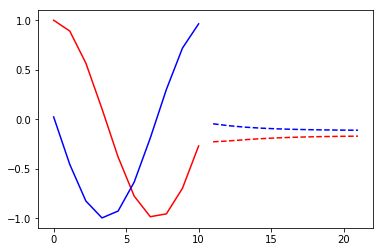

In [21]:
print('Display predictions before training.')
plot_y = test_output.data.numpy()
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
target_x = x_axis+11
plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
plt.show()

In [22]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
next_hidden = None

step: 0 , loss: 0.504897


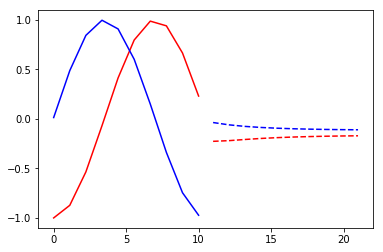

step: 50 , loss: 0.0455623


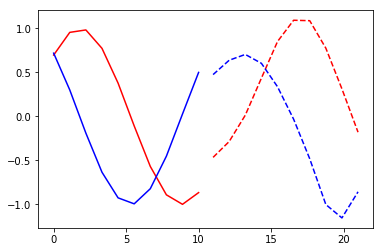

step: 100 , loss: 0.00332452


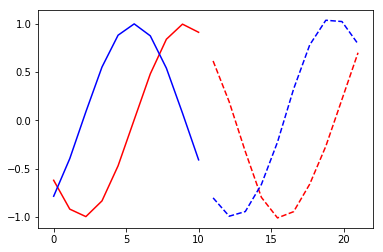

In [23]:
for step in range(nb_iters):
    temp_x, temp_y = generate_data(isTrain=True, batch_size=batch_size)
    x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
    y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
    optimizer.zero_grad()
    prediction = model(x)   # rnn output
    loss = loss_func(prediction, y)
    if step % 50 == 0:
        print('step:', step, ', loss:', loss.data.numpy()[0])
        plot_y = prediction.data.numpy()
        plt.figure()
        plt.yticks(np.linspace(-1,1,5))
        plt.plot(x_axis, temp_x[:, i, 0], 'r', x_axis, temp_x[:, i, 1], 'b')
        plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
        plt.show()
    loss.backward()
    optimizer.step()

In [26]:
temp_x, temp_y = generate_data(isTrain=False, batch_size=1)
x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
prediction = model(x)
prediction = prediction.data.numpy()
print(temp_x.shape)
print(prediction.shape)

(10, 1, 2)
(10, 2)


Display prediction after training.


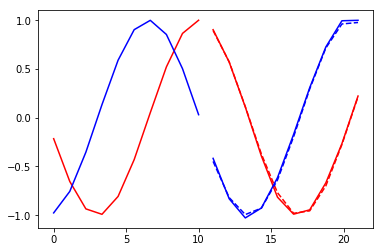

In [27]:
print('Display prediction after training.')
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, temp_x[:, 0, 0], 'r', x_axis, temp_x[:, 0, 1], 'b')
target_x = x_axis+11

plt.plot(target_x, temp_y[:, 0, 0], 'r--', target_x, temp_y[:, 0, 1], 'b--')
plt.plot(target_x, prediction[:, 0], 'r', target_x, prediction[:, 1], 'b')
plt.show()